Calculo del atlas 0 y del atlas 1 con las imagenes de ADNI1

Instalamos volxelmorph

In [ ]:
pip install voxelmorph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 6.1 MB/s eta 0:00:00


In [ ]:
import voxelmorph as vxm

Obtenemos el modelo preentrenado

In [ ]:
!wget https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/models/vxm_dense_brain_T1_3D_mse.h5

--2023-04-23 10:30:04--  https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/models/vxm_dense_brain_T1_3D_mse.h5
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1323288 (1.3M)
Saving to: ‘vxm_dense_brain_T1_3D_mse.h5’

vxm_dense_brain_T1_ 100%[===================>]   1.26M  4.33MB/s    in 0.3s    

2023-04-23 10:30:04 (4.33 MB/s) - ‘vxm_dense_brain_T1_3D_mse.h5’ saved [1323288/1323288]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf

Cargamos las imagenes del drive al google colab. El formato que tenian las imagenes (182x218x182) no era aceptado por el modelo asi que se han recortado las imagenes al tamaño mas proximo que es 176x208x176. Se han usado 50 imagenes en vez de 100 ya que si no se excedia siempre la memoria RAM

In [ ]:
ruta_carpeta = '/content/drive/MyDrive/tfg/imagenesCN/'

lista_imagenes = os.listdir(ruta_carpeta)

sumaImagenes = np.zeros((1,176,208,176,1))

for nombre_imagen in lista_imagenes:
  ruta = ruta_carpeta + nombre_imagen
  print(ruta)
  imagen = nib.load(ruta).get_fdata()
  imagen = imagen[0:176,0:208,0:176]
  imagen = imagen[..., np.newaxis]
  imagen = imagen[np.newaxis, ...]
  imagen = (imagen - np.min(imagen)) / (np.max(imagen) - np.min(imagen))
  imagen.shape
  sumaImagenes = sumaImagenes + imagen

/content/drive/MyDrive/tfg/imagenesCN/002_S_0295_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_0685_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_0413_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_0559_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_1261_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/003_S_0907_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/002_S_1280_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/003_S_0931_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/003_S_0981_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/003_S_1021_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/005_S_0602_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/005_S_0223_ADNI1_MPRAGE_N3-NoSkull.nii
/content/drive/MyDrive/tfg/imagenesCN/005_S_0553_ADNI1_MPRAGE_N3-NoSkull.nii

Construimos el atlas 0 con la media de las imagenes recien cargadas

In [ ]:
atlas_cero = sumaImagenes/len(lista_imagenes)
atlas_cero.shape

(1, 176, 208, 176, 1)

In [ ]:
atlas_cero_mostrar = atlas_cero.squeeze()

MOSTRAMOS ATLAS 0

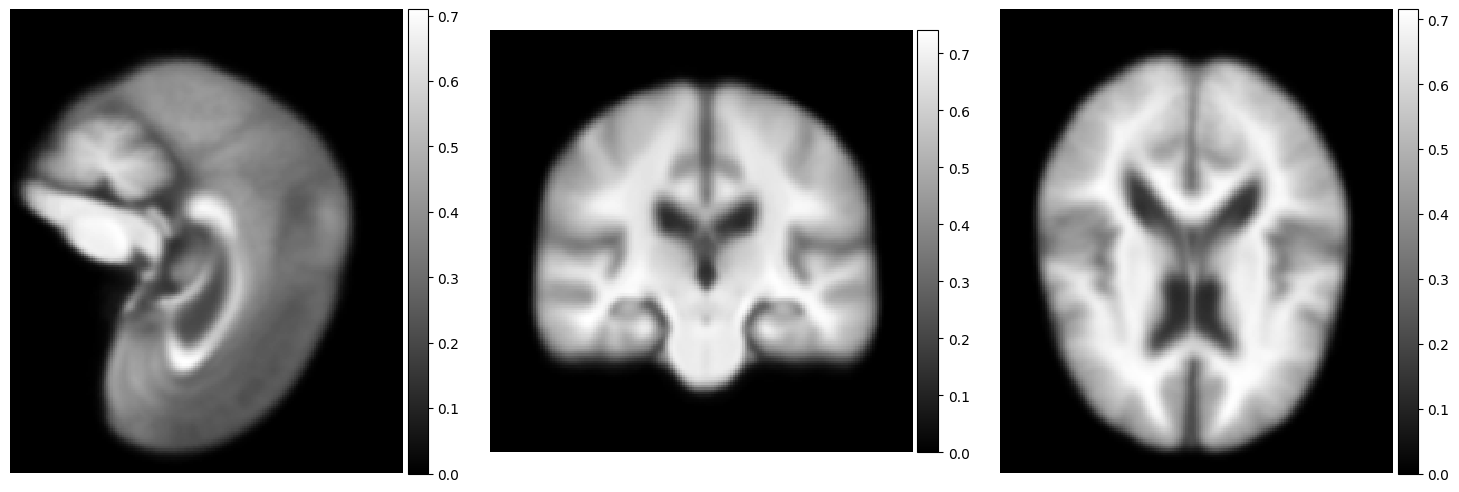

In [ ]:
import neurite as ne

vol_shape = (176, 208, 176)

mid_slices_atlas_cero_mostrar = [np.take(atlas_cero_mostrar, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_atlas_cero_mostrar[1] = np.rot90(mid_slices_atlas_cero_mostrar[1], 1)
mid_slices_atlas_cero_mostrar[2] = np.rot90(mid_slices_atlas_cero_mostrar[2], -1)

ne.plot.slices(mid_slices_atlas_cero_mostrar, cmaps=['gray'], do_colorbars=True);

Guardamos el atlas 0 en drive

In [ ]:
np.save('/content/drive/MyDrive/tfg/atlas0.npy', atlas_cero_mostrar)

Procedemos a calcular la deformacion y la imagen moved de cada imagen respecto del altas 0. De la predicción obtenemos una tupla en la que la posicion 0 representa la imagen moved y la posicion 1 el campo de deformación. Guardamos en un array todas las imagenes moved.

In [ ]:
inshape = atlas_cero.shape[1:-1]
nb_feats = atlas_cero.shape[-1]

print(inshape)
print(nb_feats)

gpu = 0
device, nb_devices = vxm.tf.utils.setup_device(gpu)

array_result = np.zeros((1,176,208,176,1))

with tf.device(device):
    # load model and predict
    config = dict(inshape=inshape, input_model=None)
    model = vxm.networks.VxmDense.load('vxm_dense_brain_T1_3D_mse.h5', **config)

    for nombre_imagen in lista_imagenes:
      ruta = ruta_carpeta + nombre_imagen
      print(ruta)
      imagen = nib.load(ruta).get_fdata()
      imagen = imagen[0:176,0:208,0:176]
      imagen = imagen[..., np.newaxis]
      imagen = imagen[np.newaxis, ...]
      imagen = (imagen - np.min(imagen)) / (np.max(imagen) - np.min(imagen))
      imagen.shape
      val_pred = model.predict([imagen, atlas_cero])
      array_result = array_result + val_pred[0]

(176, 208, 176)
1


/usr/local/lib/python3.9/dist-packages/voxelmorph/tf/networks.py:124: UserWarning: int_downsize is deprecated, use the int_resolution parameter.
  warnings.warn('int_downsize is deprecated, use the int_resolution parameter.')
/usr/local/lib/python3.9/dist-packages/voxelmorph/tf/networks.py:129: UserWarning: unet_half_res is deprecated, use the svf_resolution parameter.
  warnings.warn('unet_half_res is deprecated, use the svf_resolution parameter.')


/content/drive/MyDrive/tfg/imagenesCN/002_S_0295_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 15s 15s/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_0685_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 493ms/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_0413_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 470ms/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_0559_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 481ms/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_1261_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 486ms/step
/content/drive/MyDrive/tfg/imagenesCN/003_S_0907_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 482ms/step
/content/drive/MyDrive/tfg/imagenesCN/002_S_1280_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [==============================] - 0s 473ms/step
/content/drive/MyDrive/tfg/imagenesCN/003_S_0931_ADNI1_MPRAGE_N3-NoSkull.nii
1/1 [=========

Calculamos el altas 1 con la media de lo obtenido anteriormente

In [ ]:
atlas_uno = array_result/len(lista_imagenes)
atlas_uno.shape

(1, 176, 208, 176, 1)

In [ ]:
atlas_uno_mostrar = atlas_uno.squeeze()

MOSTRAMOS ATLAS 1

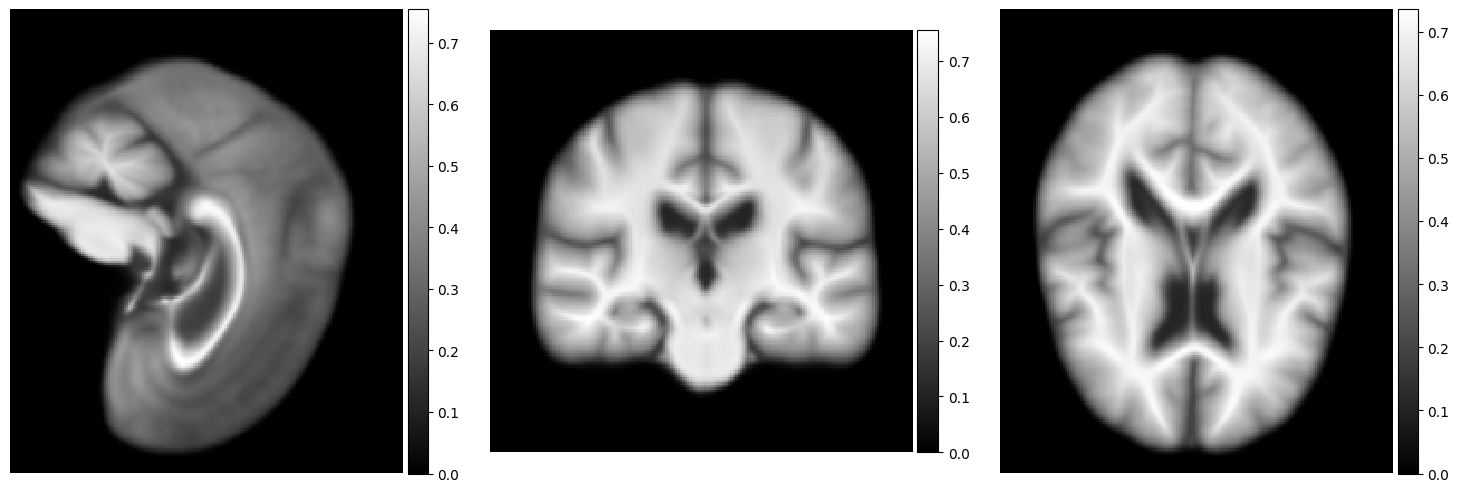

In [ ]:
mid_slices_atlas_uno_mostrar = [np.take(atlas_uno_mostrar, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_atlas_uno_mostrar[1] = np.rot90(mid_slices_atlas_uno_mostrar[1], 1)
mid_slices_atlas_uno_mostrar[2] = np.rot90(mid_slices_atlas_uno_mostrar[2], -1)

ne.plot.slices(mid_slices_atlas_uno_mostrar, cmaps=['gray'], do_colorbars=True);

Guardamos las imagenes en drive

In [ ]:
np.save('/content/drive/MyDrive/tfg/atlas1.npy', atlas_uno_mostrar)